### Machine Learning for Systems & Control 5SC27 2020-2021

# Exercise set W1 ML basics in python


This exercise set is meant to be completed after going over the introductory python notebook.

In this exercise set, we will go over the basics of ML in python and illustrate a few of the key ideas. 

## Exercise 1: Manual Linear Regression

One of the most simple models one can estimate is the linear model:
$$
Y = X \beta + \epsilon
$$

where $Y$ is the observed output, $X$ the system input, $\beta$ the parameter vector which needs to be estimated and $\epsilon$ some unkown zero mean noise. 

Estimating such a model is called linear regression and is generally done by [Linear Least Sqaures](https://en.wikipedia.org/wiki/Ordinary_least_squares). This is generally done by solving the following overdetermined system of equations

$$
X \beta = Y \\
$$
This can be solved using the following projection steps
$$
X^T X \beta = X^T Y\\
 \beta = (X^T X)^{-1} X^T Y
$$


**a)** Write a linear data generating function `f0` which generates output data $Y$ (`Ydata`) for the given $X$ (`Xdata`) and $\beta_0=(0.5,-0.9)$ (`beta0`). Also note that `f0` includes an argument for the amout of noise which will be added to the output. 

*tip: use np.dot or the matrix multiply `@` operator*

**b)** Make a scatter plot with both inputs as (x1,y) and (x2,y).

*tip: use the format plt.plot(x,y,'.')*

**c)** Estimate $\beta$ using Linear Least Squares as seen above and compare to $\beta_0$. Why is there a difference?

*tip: do not use np.linalg.inv use np.linalg.solve insteed (is a generally lot faster)*

*tip: a.T or np.transpose(a) will transpose an array and use `@` for matrix multiply*

**Answer c):** There is a difference due to the noise which is present in the measurements $Y$.

**d)** Use the estimated $\beta$ to make a residual plot which plots both `y` and `y - y_pred` where `y_pred` is the predicted output using the estimated $\beta$.

*tip: you can reuse `f0` by setting noise_scale to zero*

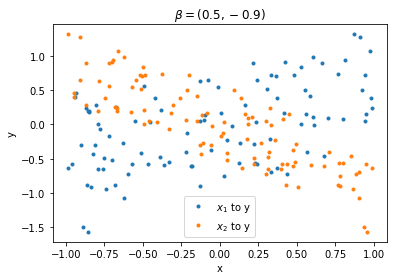

beta predicted= [ 0.50146588 -0.89601661]
     beta real= [ 0.5 -0.9]


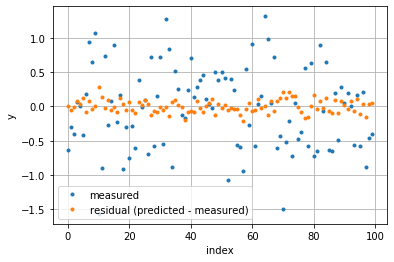

In [2]:
import numpy as np

def f0(x, beta, noise_scale=0.1):
    y = x@beta #a=)
    return y + np.random.normal(scale=noise_scale,size=x.shape[0])  #add some noise of scale noise_scale

beta0 = np.array([0.5,-0.9])
Nsamps = 100
Xdata = np.random.uniform(low=-1,high=1,size=(Nsamps,beta0.shape[0]))
Ydata = f0(Xdata, beta=beta0) #a=)

from matplotlib import pyplot as plt
plt.title(r'$\beta = (0.5,-0.9)$') #b)
plt.plot(Xdata[:,0], Ydata,'.',label='$x_1$ to y') #b)
plt.plot(Xdata[:,1], Ydata,'.',label='$x_2$ to y') #b)
plt.xlabel('x'); plt.ylabel('y'); plt.legend() #b)
plt.show() #b)

beta_p = np.linalg.solve(Xdata.T@Xdata, Xdata.T@Ydata) #c=)
print('beta predicted=', beta_p) #c)
print('     beta real=', beta0) #c)

Ypred = f0(Xdata, beta=beta_p, noise_scale=0) #d)
plt.plot(Ydata,'.',label='measured') #d)
plt.plot(Ypred-Ydata,'.',label='residual (predicted - measured)') #d)
plt.xlabel('index'); plt.ylabel('y'); plt.legend() #d)
plt.grid() #d)
plt.show() #d)

## Exercise 2: Linear Regression using sklearn

[Sklearn](https://scikit-learn.org/stable/) can simplify the model estimation process and reduce coding errors. It implements most basic machine learning methods including some deep learning methods. 


**a)** run the cell and compare the results with the last exercise.

**b)** Do a residual amplitude analysis by use `reg.predict` to calculate the root mean square error (RMS) and the Normalized RMS (NRMS) (closely related to $R^2$) which are defined as follows

$$
\text{RMS} = \sqrt{\frac{1}{N} \sum_{i=0}^{N-1} (\hat{y}_i - y_i)^2} \\
\text{NRMS} = \frac{\text{RMS}}{\sigma_y} \\
\sigma_y = \sqrt{\frac{1}{N} \sum_{i=0}^{N-1} (\bar{y} - y_i)^2} \\
\bar{y} = \frac{1}{N} \sum_{i=0}^{N-1} y_i
$$

where $\hat{y}_i$ is the ith predicted output and $y_i$ the measured output, $\sigma_y$ the standard deviation and $\bar{y}$ the average. 

*tip: use np.mean and np.std*

**c)** If the NRMS would be 1 what would that say about the model? 

**Answer c):** That the model is no better than a model which only predicts the average.

**d)** Make a residual plot like in 1d).

In [2]:

def f0(x,beta=np.pi,noise_scale=0.1):
    y = x@beta
    return y + np.random.normal(scale=noise_scale,size=x.shape[0])

#generate data
beta0 = np.array([0.5,-0.9])
Nsamps = 100
Xdata = np.random.uniform(low=-1,high=1,size=(Nsamps,beta0.shape[0]))
Ydata = f0(Xdata,beta=beta0) 

#fit the data
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(Xdata,Ydata)

#print resulting fit
print('beta predicted=',reg.coef_)
print('     beta real=',beta0)

Ypred = reg.predict(Xdata) #b)

RMS = np.mean((Ypred - Ydata)**2)**0.5 #b)
NRMS = RMS/np.std(Ydata) #b)

print('RMS=', RMS) #b)
print('NRMS=', NRMS) #b)

plt.plot(Ydata,'.',label='measured') #d)
plt.plot(Ypred-Ydata,'.',label='residual (predicted - measured)') #d)
plt.xlabel('index'); plt.ylabel('y'); plt.legend(); plt.grid() #d)
plt.show() #d)

NameError: name 'np' is not defined

## Exercise 3: Polynomial regression and regularization by train, validation and test splitting.

Any data-driven approach should keep overfitting in mind. For instance; the most lowest Root Mean Square Error (RMS) on the training data might also be one of the worst-performing models. In this exercise, we will showcase where this effect comes from and how to correct for it. 

We will fit a sine 

$$
 y = \sin(10 x) + \epsilon
$$

with some measurement noise $\epsilon$ with a polynomial of varying degree $d$. 

$$
 \hat{y} = a_0 + a_1 x + a_2 x^2 + ... + a_d x^d
$$

**a)** Inspect and run the code.

**b)** Why does the RMS train go down when increasing the polynomial degree?

**Answer b):** Using a higher-order polynomial has more parameters (i.e. degrees of freedom) hence the fit can become more accurate on the data.

**c)** The model of degree 25 has the lowest RMS on the training data. Why should it not be used on unseen data? 

**Answer c):** The estimated polynomial fluctuates an unreasonable amount such that it will not be able to accurately predict any new data.

**d)** What degree would you pick as providing the best model?

**Answer d):** Around degree 11 the fluctuations are not that large and the fit is accurate.

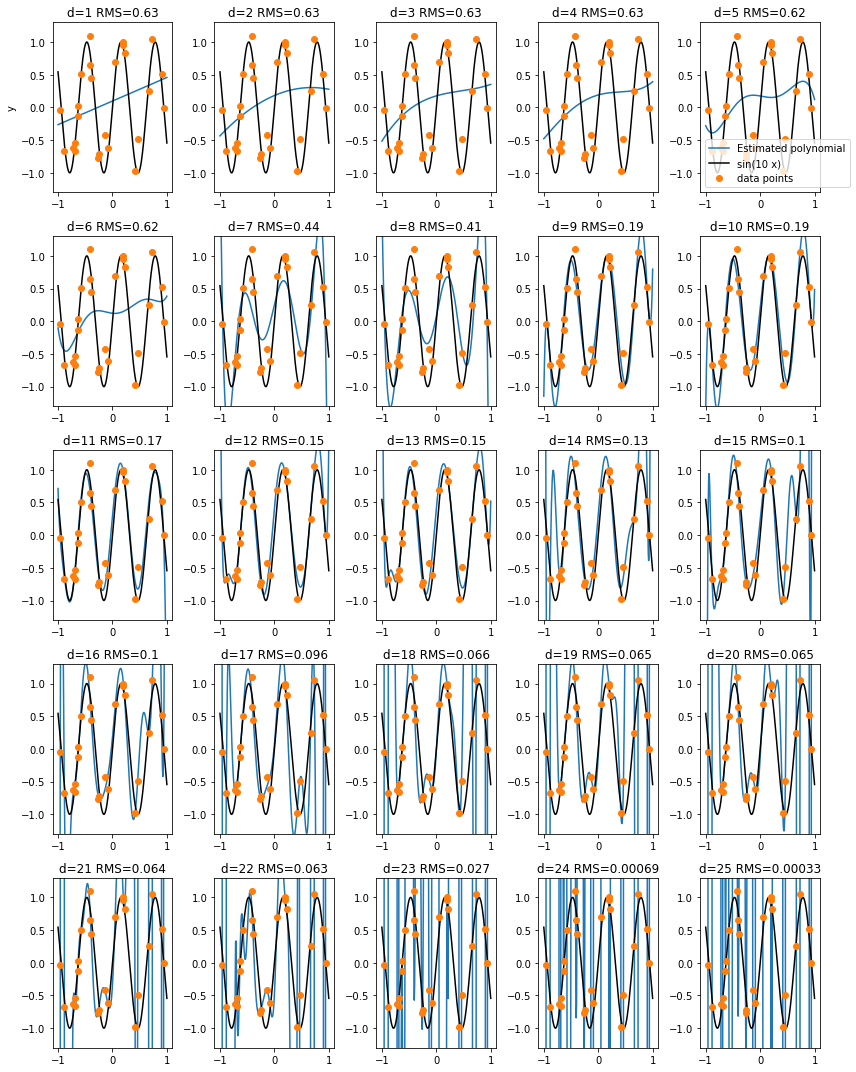

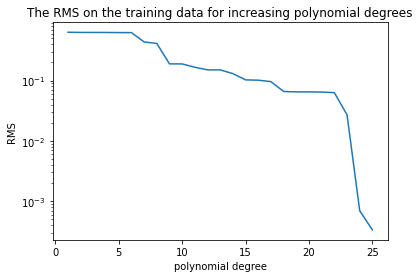

In [3]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def f0(x):
    return np.sum(np.sin(x*10),axis=1)

np.random.seed(42)
Nsamples = 25
Xfull = np.random.uniform(low=-1,high=1,size=(Nsamples,1)) 
Yfull = f0(Xfull) + np.random.normal(scale=0.2,size=Xfull.shape[0]) 

Xtest = np.linspace(-1,1,num=300)[:,None]
Ytest = f0(Xtest)

degrees = list(range(1,Nsamples+1,1))
errors = []
plt.figure(figsize=(12,np.ceil(len(degrees)/5)*3))
for i,degree in enumerate(degrees):
    #model 
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression())])
    model.fit(Xfull,Yfull)
    
    
    #calculating RMS and saving
    p = lambda x: model.predict(x)
    error = np.mean((p(Xfull)-Yfull)**2)**0.5
    errors.append(error)
    
    #plotting
    plt.subplot(int(np.ceil(len(degrees)/5)), 5, i+1)
    plt.title('d='+str(degree)+f' RMS={error:.2}')
    plt.plot(Xtest, p(Xtest),label='Estimated polynomial')
    plt.ylim(-1.3,1.3)
    plt.plot(Xtest, Ytest,'k',label='sin(10 x)')
    plt.plot(Xfull,Yfull,'o',label='data points')
    if i==4:
        plt.legend()
    if i==0:
        plt.ylabel('y')
    plt.tight_layout()
plt.show()    
plt.semilogy(degrees,errors)
plt.title('The RMS on the training data for increasing polynomial degrees')
plt.xlabel('polynomial degree')
plt.ylabel('RMS')
plt.show()

Manually selecting the polynomial degree (i.e. model complexity) is not quantativative nor automatic. To solve this we can introduce validation data sets. The general idea is 
 
 1. Split off a part of the training data (randomly) into a separate validation data set.
 2. Fit/train the model using the left over training data (without using the validation set)
 3. Calculate the RMS or equivalent on the unseen validation set data to quantify the generalization capacity. 
 4. Pick the polynomial degree with the lowest RMS error on the validation set.
 
Let's apply this methodology on picking the polynomial degree. 
 
**e)** Split the data into a deticated training and validation set for the given fraction `val_frac`. (Use `Xfull` and `Yfull` from previous cell and split into `Xtrain`, `Ytrain`, `Xval` and `Yval`). Run the cell and observe the behaviour of the RMS train and RMS validation for increasing polynomial degree.

**f)** picking and print the degree with the lowest validation RMS. (use the list of RMS val `errors_val`)

*tip: use np.argmin*

**g)** Can you connect these ideas to the variance-bias trade-off you saw in the lecture?

additional information: These are the basics of model complexity selection using a validation set. However, there are more advanced methods available such as k-fold cross-validation [Example](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

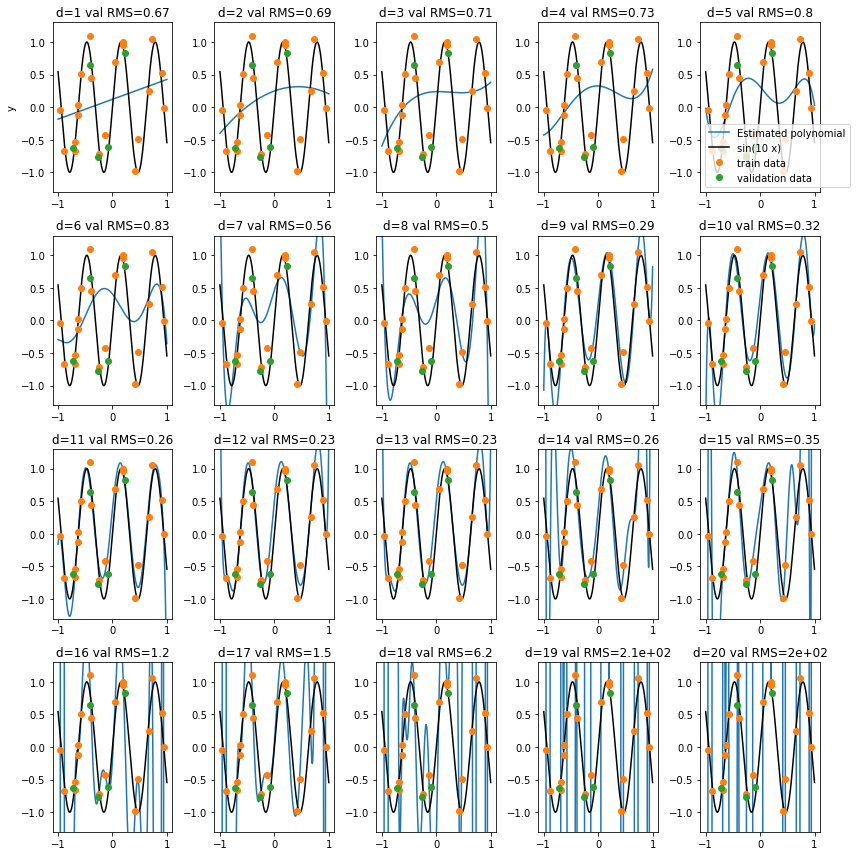

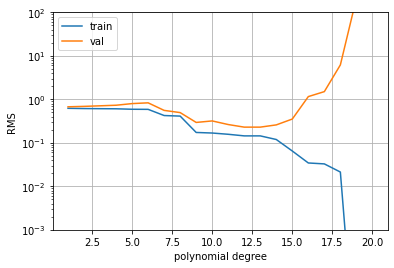

best degree= 12


In [4]:
val_frac = 0.2
pivit = int((1-val_frac)*Xfull.shape[0]) #e)
#The data is already suffeld randomlly so we don't have to do it again #e)
Xtrain = Xfull[:pivit] #e=)
Xval   = Xfull[pivit:] #e=)
Ytrain = Yfull[:pivit] #e=)
Yval   = Yfull[pivit:] #e=)

Xtest = np.linspace(-1,1,num=300)[:,None]
Ytest = f0(Xtest)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

degrees = list(range(1,Xtrain.shape[0]+1,1))
errors_val = []
errors_train = []
models = []
plt.figure(figsize=(12,np.ceil(len(degrees)/5)*3))
for i,degree in enumerate(degrees):
    
    #model construction and estimation
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression(fit_intercept=False))])
    model.fit(Xtrain,Ytrain)
    models.append(model)

    #errors
    error_val_now = np.mean((model.predict(Xval)-Yval)**2)**0.5
    error_train_now = np.mean((model.predict(Xtrain)-Ytrain)**2)**0.5
    errors_val.append(error_val_now)
    errors_train.append(error_train_now)
    
    #plotting    
    plt.subplot(int(np.ceil(len(degrees)/5)), 5, i+1)
    plt.title('d='+str(degree)+f' val RMS={error_val_now:.2}')
    plt.plot(Xtest, p(Xtest),label='Estimated polynomial')
    plt.ylim(-1.3,1.3)
    plt.plot(Xtest, Ytest,'k',label='sin(10 x)')
    plt.plot(Xtrain,Ytrain,'o',label='train data')
    plt.plot(Xval,Yval,'o',label='validation data')
    if i==4:
        plt.legend()
    if i==0:
        plt.ylabel('y')
    plt.tight_layout()

plt.show()    
plt.semilogy(degrees,errors_train,label='train')
plt.semilogy(degrees,errors_val,label='val')
plt.ylim(1e-3,1e2)
plt.xlabel('polynomial degree')
plt.ylabel('RMS')
plt.legend()
plt.grid()
plt.show()

print('best degree=',degrees[np.argmin(errors_val)]) #f)
best_model = models[np.argmin(errors_val)] #f)

## Exercise 4: Dynamical Systems modelling

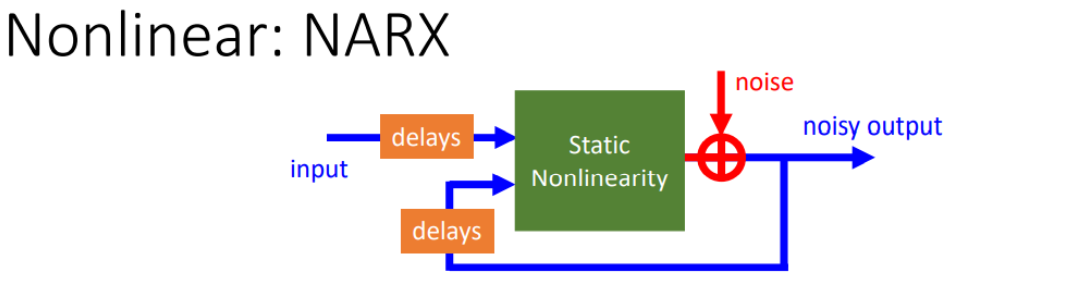


Nonlinear dynamical systems can be modeled using the NARX model class. Here you will estimate a polynomial NARX model. 

The NARX model structure is given by:

$$
y_k = f(u_{k-1},u_{k-2},...,u_{k-n_b},y_{k-1},y_{k-2},...,y_{k-n_a}) + e_k
$$

where $u_k$ is the input, $y_k$ the measured output, and $e_k$ the zero mean white noise at time instant $k$. Sometimes $u_k$ is included in $f$ but in this case we have left it out as the considered system does not have direct feedthrough term. The considered system is given by:

$$
y_k = \left (0.8 - 0.5 \exp \left ( -y_{k-1}^2 \right ) \right ) y_{k-1} - \left  (0.3 + 0.9 \exp \left ( -y_{k-1}^2\right )\right ) y_{k-2} + u_{k-1} + 0.2 u_{k-2} + 0.1 u_{k-1} u_{k-2} + e_k
$$


**a)** Complete the get_NARX_data function for a given function $f$ where the past arrays are continuously updated.

*tip: write down the model structure on a piece of paper before you start implementing the equations*

**b)** To estimate this model you will need to structure the data structure in the form we have used before: `Xdata.shape = (Nsamp, Nfeatures)` and `Ydata = (Nsamp)` where each row of `Xdata` is given by $(u_{k-2} \ u_{k-1} \ y_{k-2} \ y_{k-1})$ for $n_a=2$ and $n_b=2$ and the elements of `Ydata` are simply $y_k$. Construct the input and output arrays required for training. 


*tip: use np.concatenate and .append*

**c)** Split the data into train and validation 

*tip: use train_test_split provided by sklearn*

In [5]:
import numpy as np
from matplotlib import pyplot as plt
def f(upast,ypast):
    ukm2, ukm1 = upast
    ykm2, ykm1 = ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
           + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2
    return ystar + np.random.normal(scale=0.01)

#make data sequence a)
def get_NARX_data(ulist, f, na, nb):
    # itteratively uses the given f to find the new output.
    
    #init upast and ypast as lists.
    upast = [0]*nb #a=)
    ypast = [0]*na #a=)
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) #a=)
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

na, nb = 2, 2

np.random.seed(42)
ulist = np.random.normal(scale=1,size=1000)
ylist = get_NARX_data(ulist,f,na,nb)

#construct training data in correct form b)
def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to not get indexing errors
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) #b)
        Ydata.append(ylist[k]) #b)
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist,ylist, 2, 2)

#split data c)
from sklearn.model_selection import train_test_split #c)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) #c)

**d)** Find the model with the lowest validation RMS for increasing polynomial degree ranging from 1 to 5. Print the NRMS of the model with the lowest NRMS validation error.

*tip: copy code from the last exercise*

**e)**  Make a residual plot.

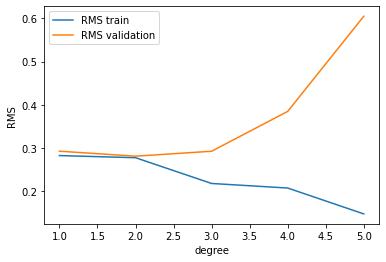

NRMS val one step: 0.280812518120024
degree= 2


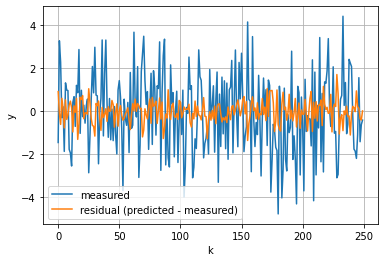

In [6]:
#model construction
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression

degrees = [1,2,3,4,5] #d)
errors_val = [] #d)
errors_train = [] #d)
models = [] #d)
for i,degree in enumerate(degrees): #d)
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), #d)
                  ('linear', LinearRegression(fit_intercept=True))]) #d)
    model.fit(Xtrain,Ytrain) #d)
    models.append(model) #d)
    p = lambda x: model.predict(x) #d)
    error_val = np.mean((p(Xval)-Yval)**2)**0.5/np.std(Yval) #d)
    error_train = np.mean((p(Xtrain)-Ytrain)**2)**0.5/np.std(Ytrain) #d)
    errors_val.append(error_val) #d)
    errors_train.append(error_train) #d)


plt.plot(degrees,errors_train) #d)
plt.plot(degrees,errors_val) #d)
plt.xlabel('degree') #d)
plt.ylabel('RMS') #d)
plt.legend(['RMS train','RMS validation']) #d)
plt.show() #d)
print('NRMS val one step:',min(errors_val)) #d)
print('degree=',degrees[np.argmin(errors_val)]) #d)
best_model = models[np.argmin(errors_val)] #d)

plt.plot(Yval,'-',label='measured') #e)
plt.plot(best_model.predict(Xval)-Yval,'-',label='residual (predicted - measured)') #e)
plt.xlabel('k'); plt.ylabel('y'); plt.legend(); plt.grid() #e)
plt.show() #e)

**f)** Do a simulation analysis using the estimated model (i.e. re-use the model to the next step with the prediction from the last step). Compare the NRMS simulation to the NRMS one-step-ahead obtained from e). Also, make a residual plot.

**g)** Why is the NRMS one-step-ahead error lower than the NRMS simulation error?

**Answer g):** We minimized the one-step-ahead error hence most often other measures will be worse. 

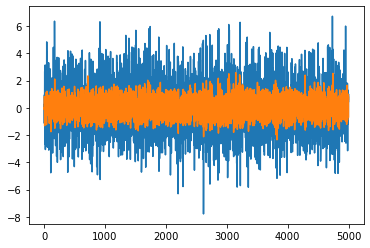

NRMS= 0.366966594918619


In [7]:

np.random.seed(43)
utest = np.random.normal(scale=1.0,size=5000)
ytest = get_NARX_data(utest,f,na,nb)

model_now = best_model #f=)
ytest_sim = get_NARX_data(utest,lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0], na, nb)
plt.plot(ytest) #f)
plt.plot(ytest-ytest_sim) #f)
plt.show() #f)

print('NRMS=',np.mean((ytest-ytest_sim)**2)**0.5/np.std(ytest)) #f)


## Exercise 5: Design Assignment Environment.

**a)** Install the design environment of the unbalanced disk.

**b)** Test the environment using the visual

*note: $-4 \leq u \leq 4$*

In [1]:
#if you havent already you need to install git
#go to anaconda navigator and open "cmd.exe"
#      type `conda install -c anaconda git`
#afterwards you can install the environment from the notebook using: 
!pip install git+git://github.com/GerbenBeintema/gym-unbalanced-disk@master

  Cloning git://github.com/GerbenBeintema/gym-unbalanced-disk (to revision master) to c:\users\gerbe\appdata\local\temp\pip-req-build-vppuw0ox


  Running command git clone -q git://github.com/GerbenBeintema/gym-unbalanced-disk 'C:\Users\gerbe\AppData\Local\Temp\pip-req-build-vppuw0ox'


In [9]:
import gym, time
import gym_unbalanced_disk #is required
import numpy as np
env = gym.make('unbalanced-disk-v0',dt=0.05) #if this fails restart the kernel or use gym_unbalanced_disk.UnbalancedDisk


In [10]:
obs = env.reset()
try:
    for i in range(200):
        obs, reward, done, info = env.step(env.action_space.sample()) #random 
        print(obs,reward)
        env.render()
        time.sleep(1/24)
        if done:
            obs = env.reset()
finally: #this will always run such to close the visualization
    env.close()

[-0.07038065 -0.99752021  2.61700227] 6.60740829807588e-11
[-0.16987188 -0.98546616  1.30618199] 2.9631779788553966e-10
[-0.23527116 -0.97192977  1.40326514] 8.176815669564681e-10
[-0.18838182 -0.98209587 -3.21552482] 4.010129378331591e-10
[-0.09928345 -0.99505919 -0.29700858] 1.0743065170395304e-10
[-0.0250755  -0.99968556 -2.57113754] 3.423662419547395e-11
[ 0.0907221  -0.99587625 -1.91054207] 8.974792762562006e-11
[ 0.11653738 -0.99318631  0.71770835] 1.3944477751158652e-10
[ 0.14948448 -0.98876407 -1.8471392 ] 2.1941919807932656e-10
[ 0.20872672 -0.97797401 -0.61973473] 5.505070684337396e-10
[ 0.21784584 -0.97598319  0.29972139] 6.155474334531726e-10
[ 0.23840568 -0.97116566 -1.08561172] 8.329697415201651e-10
[ 0.30476788 -0.95242666 -1.56497203] 2.200992056586174e-09
[ 0.35646044 -0.93431042 -0.60941302] 4.7538267490622635e-09
[ 0.37975105 -0.92508872 -0.38375889] 6.735922193393566e-09
[ 0.29263725 -0.95622353  3.81246873] 1.926128133741945e-09
[ 0.03313029 -0.99945104  6.37998964

[-0.22388943 -0.97461455 -0.52886518] 6.867015194273269e-10
[-0.09493842 -0.99548315 -4.47363436] 9.951440026884025e-11
[ 0.1367434  -0.9906065  -4.59280445] 1.8574255963792025e-10
[ 0.25149213 -0.96785934 -0.04315162] 1.0207557459655486e-09
[ 0.14825768 -0.98894877  4.03793861] 2.213997721650072e-10
[-0.13030865 -0.99147348  6.82552783] 1.7019398715930495e-10
[-0.40768916 -0.91312077  4.4855479 ] 1.036183295552437e-08
[-0.58464372 -0.81129016  3.52859746] 1.4801210310838358e-07
[-0.61696213 -0.78699284 -1.87531729] 2.4100493709206376e-07
[-0.42379597 -0.90575768 -6.87357784] 1.311296368717827e-08
[-0.06789707 -0.99769233 -7.52623129] 6.527642886863558e-11
[ 0.3268155  -0.94508816 -8.03157134] 3.0750877817077024e-09
[ 0.566275   -0.82421637 -2.59274309] 1.0942710400181645e-07
[ 0.62404143 -0.78139125 -0.29314873] 2.692756776761656e-07
[ 0.53059419 -0.84762598  4.62152642] 6.512703560424312e-08
[ 0.30460757 -0.95247794  5.13930019] 2.254560017048047e-09
[-0.01148242 -0.99993407  7.29483

**c)** extra: find an input sequence (or a controller if you prefer) that enables the disk to go over the top.

In [11]:
Umax = 4

T = 20 #c)
ulist = np.sign(np.sin(np.arange(200)/T*2*np.pi))*Umax #c=)

obs = env.reset()
try:
    for u in ulist:
        obs, reward, done, info = env.step(u)
        print(obs,reward)
        env.render()
        time.sleep(1/24)
        if done:
            obs = env.reset()
finally: #this will always run
    env.close()

[ 0.00103707 -0.99999946  0.01144512] 2.3572218180957724e-11
[-0.09230885 -0.99573042  3.5491851 ] 9.345473051186532e-11
[-0.32350924 -0.94622501  5.6611491 ] 2.961611222114482e-09
[-0.58623905 -0.81013812  5.99764507] 1.5355898429346153e-07
[-0.78614191 -0.61804603  4.90173277] 4.034249656650965e-06
[-0.89329018 -0.44948043  3.03985669] 3.379483230760835e-05
[-0.93425363 -0.35660925  0.98228258] 9.110232178063008e-05
[-0.93418456 -0.35679015 -0.93884666] 9.116406754073915e-05
[-0.89885304 -0.43825017 -2.53319591] 3.816377262018328e-05
[-0.82025965 -0.57199135 -3.60183547] 7.4900263441235865e-06
[-0.69498374 -0.71902545 -3.93962912] 8.558083014965871e-07
[ -0.38461461  -0.92307725 -10.53577443] 7.44294762750306e-09
[  0.22132139  -0.97520092 -13.54898207] 6.657949785178343e-10
[  0.77753063  -0.62884507 -12.55147919] 3.449712947612072e-06
[ 0.99175267 -0.12816643 -9.39040713] 0.0007758293032243589
[ 0.96697724  0.25486272 -6.15914517] 0.013917160129000686
[ 0.87627023  0.48181997 -3.71

[  0.51245481   0.8587142  -18.63978032] 0.48721090483786256
[ -0.39011298   0.920767   -19.79452541] 0.6729782358117234
[ -0.97128076   0.23793632 -18.12951585] 0.01227594304530716
[ -0.78679644  -0.61721257 -17.82915409] 4.112423981344256e-06
[ -0.07798936  -0.99695419 -14.59814242] 7.67233899773253e-11
[ 0.47046381 -0.88241929 -7.7613303 ] 2.679948147948223e-08
[ 0.62761135 -0.77852681  0.3016223 ] 2.852449876401423e-07
[ 0.46284938 -0.88643694  7.34102648] 2.2637480877473e-08
[-1.16223740e-02 -9.99932458e-01  1.16248284e+01] 2.6831362285367715e-11
[-0.58074089 -0.81408846 12.14954585] 1.3953120805038302e-07
[-0.92332446 -0.38402076  9.82373718] 6.900573698760889e-05
[-0.99986476  0.01644554  6.61017035] 0.002500033212745047
[-0.99652018  0.08335188 -3.76505494] 0.004100592466245049
[ -0.94321487  -0.33218324 -12.87510449] 0.00011672246381766034
[ -0.39738454  -0.91765218 -19.34120734] 8.858600405134004e-09
[  0.56828344  -0.82283287 -20.18060899] 1.1691080316119117e-07
[  0.9992008